In [1]:
import csv
import os
import sys
# Spark imports
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, count, isnull, upper, substring, to_timestamp, unix_timestamp, lit, avg
from pyspark.sql.types import IntegerType

In [2]:
sys.path.insert(0, '311_Service_Request_Analysis/src')
sys.path.insert(0, '311_Service_Request_Analysis/results/Analysis/Supervised Learning')
import Utilities as utilFor311
import Constants

In [3]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("NYC 311 Data Analysis") \
        .config('spark.sql.codegen.wholeStage', 'false') \
        .getOrCreate()
    return spark

In [4]:
filename_19 = "data/New_Data/311_Cleaned_Data_2019.csv"
filename_18 = "data/New_Data/311_Cleaned_Data_2018.csv"
Constants.RESULTS_FOLDER_ANALYSIS_Q1 = '311_Service_Request_Analysis/results/Analysis/Supervised Learning/'

In [5]:
%matplotlib inline

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def create_x_y_coordinates_for_group_by_results(group_by_result, col_name):
    '''
    Converts Group By Result (after collect()) into list of X , Y coordinates, which can then be used for Visualizations
    '''
    x = [entry.__getitem__(col_name) for entry in group_by_result]
    y = [entry.__getitem__('avg(time_to_resolve_in_hrs)') for entry in group_by_result]
    return x, y


def plot_chart_x_y(x, y, title, x_label, y_label, fig_num, x_ticks=None, x_ticks_lables=None, y_ticks=None,
                   y_ticks_lables=None, x_tick_rotation=None):
    plt.figure(num=fig_num, figsize=(8, 4))

    plt.bar(x, y, align='center', color='blue', alpha=.5)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if x_tick_rotation is not None:
        plt.xticks(rotation = x_tick_rotation)
    if x_ticks is not None:
        if x_ticks_lables is not None:
            plt.xticks(x_ticks, x_ticks_lables)
        else:
            plt.xticks(x_ticks)
    if y_ticks is not None:
        if y_ticks_lables is not None:
            plt.yticks(y_ticks, y_ticks_lables)
        else:
            plt.yticks(y_ticks)

    plt.title(title)
    plt.savefig(Constants.RESULTS_FOLDER_ANALYSIS_Q1 + str(fig_num) + '.png')


def prepare_plot(df, col_name, title, x_label, y_label, fig_num, x_ticks=None, x_ticks_lables=None, y_ticks=None,
                 y_ticks_lables=None, x_tick_rotation=None):
    df_groupby_col = df.groupby(col_name).avg().orderBy(col_name).collect()
    x, y = create_x_y_coordinates_for_group_by_results(df_groupby_col, col_name)
    plot_chart_x_y(x, y, title, x_label, y_label, fig_num, x_ticks, x_ticks_lables, y_ticks, y_ticks_lables, x_tick_rotation=x_tick_rotation)


def show_plot():
    plt.show()

In [8]:
spark = init_spark()

In [9]:
def calculate_time_to_resolve_in_seconds(df_311):
    time_fmt = "MM/dd/yyyy HH:mm:ss"
    time_fmt2 = "MM/dd/yyyy HH:mm:ss"
    timestamp_format_col = when(to_timestamp(df_311.Closed_Date, time_fmt).isNull(),
                                unix_timestamp('Closed_Date', format=time_fmt2)).otherwise(
        unix_timestamp('Closed_Date', format=time_fmt))
    df_311 = df_311.withColumn("Closing_timestamp", timestamp_format_col)
    timestamp_format_col = when(to_timestamp(df_311.Created_Date, time_fmt).isNull(),
                                unix_timestamp('Created_Date', format=time_fmt2)).otherwise(
        unix_timestamp('Created_Date', format=time_fmt))
    df_311 = df_311.withColumn("Creation_timestamp", timestamp_format_col)
    df_311 = df_311.withColumn("time_to_resolve_in_hrs", (col('Closing_timestamp') - col('Creation_timestamp')) / lit(
        3600))
    return df_311.filter(df_311["time_to_resolve_in_hrs"] > 0)

In [10]:
nyc_311_df_2019 = spark.read.csv(filename_19, inferSchema=True, header=True)
nyc_311_df_2018 = spark.read.csv(filename_18, inferSchema=True, header=True)

In [11]:
nyc_311_df_2019 = calculate_time_to_resolve_in_seconds(nyc_311_df_2019)
nyc_311_df_2018 = calculate_time_to_resolve_in_seconds(nyc_311_df_2018)

In [12]:
nyc_311_df_resolution_time_2019 = nyc_311_df_2019.select('Complaint_Type', 'time_to_resolve_in_hrs')
nyc_311_df_resolution_time_2018 = nyc_311_df_2018.select('Complaint_Type', 'time_to_resolve_in_hrs')

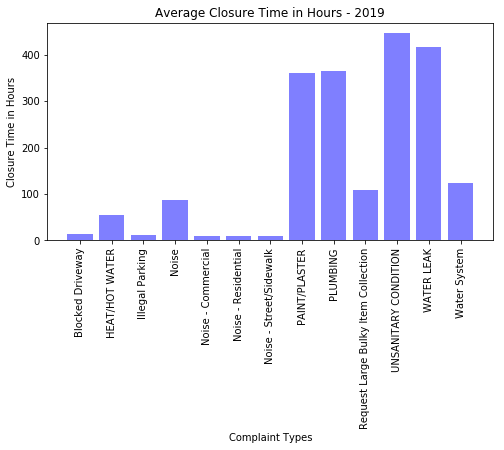

In [13]:
prepare_plot(nyc_311_df_resolution_time_2019, 'Complaint_Type',
                            "Average Closure Time in Hours - 2019", "Complaint Types", "Closure Time in Hours", 3, x_tick_rotation='vertical')

show_plot()

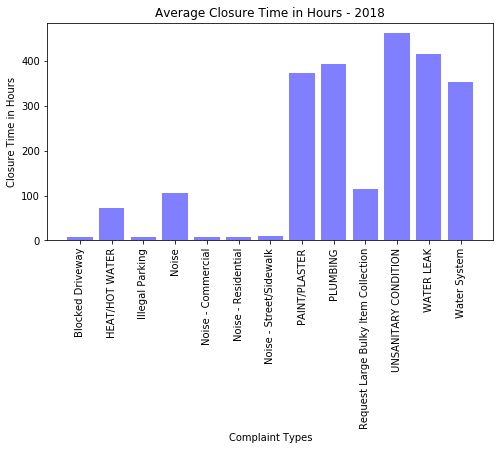

In [14]:
prepare_plot(nyc_311_df_resolution_time_2018, 'Complaint_Type',
                            "Average Closure Time in Hours - 2018", "Complaint Types", "Closure Time in Hours", 4, x_tick_rotation='vertical')

show_plot()

## Linear Regression

In [15]:
nyc_311_df_2019

DataFrame[Unique_Key: int, Closing_timestamp: bigint, Creation_timestamp: bigint, time_to_resolve_in_hrs: double, Agency: string, Agency_Name: string, Open_Data_Channel_Type: string, Status: string, Complaint_Type: string, Borough: string, Creation_Month: int, Creation_Day: int, Creation_Hour: int, Closing_Month: int, Closing_Day: int, Closing_Hour: int, Issue_Category: string, Incident_Zip: double, City: string, Latitude: double, Longitude: double, Created_Date: string, Creation_Time: string, Closed_Date: string, Closing_Time: string]

In [16]:
nyc_311_df_2019.printSchema()

root
 |-- Unique_Key: integer (nullable = true)
 |-- Closing_timestamp: long (nullable = true)
 |-- Creation_timestamp: long (nullable = true)
 |-- time_to_resolve_in_hrs: double (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Agency_Name: string (nullable = true)
 |-- Open_Data_Channel_Type: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Complaint_Type: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Creation_Month: integer (nullable = true)
 |-- Creation_Day: integer (nullable = true)
 |-- Creation_Hour: integer (nullable = true)
 |-- Closing_Month: integer (nullable = true)
 |-- Closing_Day: integer (nullable = true)
 |-- Closing_Hour: integer (nullable = true)
 |-- Issue_Category: string (nullable = true)
 |-- Incident_Zip: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Created_Date: string (nullable = true)
 |-- Creation_Time: s

In [17]:
nyc_311_df_2019.groupBy('Complaint_Type').count().show()

+--------------------+------+
|      Complaint_Type| count|
+--------------------+------+
|UNSANITARY CONDITION| 57236|
|     Illegal Parking|154566|
| Noise - Residential|195426|
|  Noise - Commercial| 34001|
|        Water System| 44943|
|    Blocked Driveway|109978|
|      HEAT/HOT WATER|203884|
|       PAINT/PLASTER| 34009|
|               Noise| 52631|
|Request Large Bul...| 99386|
|            PLUMBING| 35542|
|          WATER LEAK| 24393|
|Noise - Street/Si...| 82704|
+--------------------+------+



In [36]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="Complaint_Type", outputCol="Complaint_Type_Vector")
indexed = indexer.fit(nyc_311_df_2019).transform(nyc_311_df_2019)

In [37]:
indexed.select('Complaint_Type','Complaint_Type_Vector').head(5)

[Row(Complaint_Type='Request Large Bulky Item Collection', Complaint_Type_Vector=4.0),
 Row(Complaint_Type='HEAT/HOT WATER', Complaint_Type_Vector=0.0),
 Row(Complaint_Type='UNSANITARY CONDITION', Complaint_Type_Vector=6.0),
 Row(Complaint_Type='HEAT/HOT WATER', Complaint_Type_Vector=0.0),
 Row(Complaint_Type='HEAT/HOT WATER', Complaint_Type_Vector=0.0)]

In [38]:
indexed.columns

['Unique_Key',
 'Closing_timestamp',
 'Creation_timestamp',
 'time_to_resolve_in_hrs',
 'Agency',
 'Agency_Name',
 'Open_Data_Channel_Type',
 'Status',
 'Complaint_Type',
 'Borough',
 'Creation_Month',
 'Creation_Day',
 'Creation_Hour',
 'Closing_Month',
 'Closing_Day',
 'Closing_Hour',
 'Issue_Category',
 'Incident_Zip',
 'City',
 'Latitude',
 'Longitude',
 'Created_Date',
 'Creation_Time',
 'Closed_Date',
 'Closing_Time',
 'Complaint_Type_Vector']

In [39]:
indexed.select('Complaint_Type', 'Complaint_Type_Vector').distinct().show()

+--------------------+---------------------+
|      Complaint_Type|Complaint_Type_Vector|
+--------------------+---------------------+
|  Noise - Commercial|                 11.0|
|          WATER LEAK|                 12.0|
| Noise - Residential|                  1.0|
|        Water System|                  8.0|
|       PAINT/PLASTER|                 10.0|
|            PLUMBING|                  9.0|
|      HEAT/HOT WATER|                  0.0|
|UNSANITARY CONDITION|                  6.0|
|               Noise|                  7.0|
|Noise - Street/Si...|                  5.0|
|Request Large Bul...|                  4.0|
|     Illegal Parking|                  2.0|
|    Blocked Driveway|                  3.0|
+--------------------+---------------------+



In [75]:
num_calls_df = indexed.groupBy('Complaint_Type_Vector', 'Creation_Day','Creation_Hour').count()

In [76]:
num_calls_df.columns

['Complaint_Type_Vector', 'Creation_Day', 'Creation_Hour', 'count']

In [77]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [78]:
assembler = VectorAssembler(
  inputCols=['Complaint_Type_Vector', 'Creation_Day','Creation_Hour'],
    outputCol="features")

In [79]:
output = assembler.transform(num_calls_df)

In [80]:
output.select("features", "count").show()

+----------------+-----+
|        features|count|
+----------------+-----+
| [10.0,2.0,12.0]|  117|
|  [12.0,3.0,4.0]|    5|
| [10.0,3.0,12.0]|  102|
| [10.0,3.0,17.0]|   50|
|   [9.0,4.0,2.0]|    5|
|   [9.0,4.0,5.0]|    9|
| [10.0,4.0,14.0]|  114|
|  [10.0,5.0,9.0]|   87|
| [12.0,7.0,18.0]|   33|
|   [9.0,9.0,7.0]|   21|
|[12.0,10.0,11.0]|   65|
| [9.0,10.0,14.0]|   80|
|[12.0,13.0,14.0]|   50|
| [4.0,14.0,19.0]|  189|
| [4.0,15.0,12.0]|  225|
| [9.0,19.0,15.0]|   73|
| [0.0,19.0,21.0]|  416|
| [8.0,22.0,20.0]|   66|
|  [8.0,25.0,2.0]|   16|
| [12.0,25.0,7.0]|   15|
+----------------+-----+
only showing top 20 rows



In [81]:
final_data = output.select("features", "count")

In [82]:
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [83]:
from pyspark.ml.regression import LinearRegression
# Create a Linear Regression Model object
lr = LinearRegression(labelCol='count')

In [84]:
# Fit the model to the data and call this model lrModel
lrModel = lr.fit(train_data)

In [85]:
# Print the coefficients and intercept for linear regression
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

Coefficients: [-20.77539241728782,-0.5833390435406884,6.683113952020992] Intercept: 175.28314171493946


In [86]:
test_results = lrModel.evaluate(test_data)

In [87]:
print("RMSE: {}".format(test_results.rootMeanSquaredError))
print("MSE: {}".format(test_results.meanSquaredError))
print("R2: {}".format(test_results.r2))

RMSE: 87.59594750550254
MSE: 7673.050019386756
R2: 0.4751228911854294


In [88]:
predictions = lrModel.transform(test_data)

In [89]:
predictions.show()

+---------------+-----+-------------------+
|       features|count|         prediction|
+---------------+-----+-------------------+
|[1.0,18.0,22.0]|  827|  291.0361534583811|
|[1.0,26.0,10.0]|   58| 206.17207368580367|
|[2.0,15.0,15.0]|  290|  225.2289805075684|
| [5.0,4.0,19.0]|  178| 196.05198854273647|
| [5.0,9.0,13.0]|   40| 153.03660961290706|
|[5.0,16.0,21.0]|  320|  202.4181479242902|
| [7.0,7.0,19.0]|   73| 152.75118657753876|
|  [9.0,2.0,4.0]|    6| 13.870387680351655|
|  [9.0,4.0,2.0]|    5|-0.6625183107717021|
|  [9.0,9.0,7.0]|   21|  29.83635623162982|
|[9.0,10.0,14.0]|   80|  76.03481485223608|
| [10.0,5.0,9.0]|   87| 24.760547892546754|
| [10.0,7.0,5.0]|    4| -3.138586002618581|
|[11.0,14.0,8.0]|    5| -7.948009868628219|
| [1.0,11.0,0.0]|   53| 148.09101981870407|
|  [2.0,8.0,9.0]|  260| 189.21367010022726|
|[3.0,11.0,17.0]|  191|  220.1531721684853|
| [3.0,14.0,4.0]|   33| 131.52267366159032|
| [4.0,11.0,8.0]|  138| 139.22975418300854|
|[5.0,10.0,16.0]|   74| 172.5026

### Find the correlation using Pearson Correlation

In [31]:
from pyspark.sql.functions import corr

In [46]:
nyc_311_df_2019.select(corr('Creation_Month','time_to_resolve_in_hrs')).show()

+--------------------------------------------+
|corr(Creation_Month, time_to_resolve_in_hrs)|
+--------------------------------------------+
|                        -0.08010677112024123|
+--------------------------------------------+



In [48]:
nyc_311_df_2019.select(corr('Creation_Hour','time_to_resolve_in_hrs')).show()

+-------------------------------------------+
|corr(Creation_Hour, time_to_resolve_in_hrs)|
+-------------------------------------------+
|                       -0.03296325095489546|
+-------------------------------------------+

